In [104]:
import gym
import numpy as np
import random
import math
from itertools import count

import sklearn.pipeline
import sklearn.preprocessing
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


env = gym.envs.make("MountainCarContinuous-v0")
env._max_episode_steps = 2000
# print("Action space: ", env.action_space, "\nHigh: ", env.action_space.high, "Low: ", env.action_space.low)
# print("Observation space: ", env.observation_space, "\nHigh: ", env.observation_space.high, "Low: ", env.observation_space.low)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/mquan/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


# Abstract class of Baseline & Policy  
Key point of this class is the definition of the featurizer based on Radial Basis Function (RBF). This featurizer is used for featurizing state before calculating the value of the Baseline or the action produce by the Policy.

In [120]:
class PolicyGradient(object):
    def __init__(self, num_features, _examples):
        '''
        num_features: define len of weights vector of the linear model (used as either Actor or Critic)
        _examples: sample for either observation space or (obs, act) space to normalize the scaler to 
                    zero mean & unit variance
        '''
        assert num_features % 4 == 0  # 4 featurizers
        self.weights = np.zeros(num_features)
        # define & normalize scaler
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(_examples)
        # define featurizer
        num_components = num_features // 4
        self.featurizer = state_featurizer = sklearn.pipeline.FeatureUnion([
                ("rbf1", RBFSampler(gamma=5.0, n_components=num_components)),
                ("rbf2", RBFSampler(gamma=2.0, n_components=num_components)),
                ("rbf3", RBFSampler(gamma=1.0, n_components=num_components)),
                ("rbf4", RBFSampler(gamma=0.5, n_components=num_components))
                ])
        self.featurizer.fit(self.scaler.transform(_examples))
        
    def featurize(self, *argv):
        '''
        Accepted input: state or state, action
        '''
        assert len(argv) in [1, 2]
        if len(argv) == 2:
            # featurize a (state, action) pair
            scaled = self.scaler.transform([np.append(argv[0], argv[1])])
        else:
            # featurize a state
            scaled = self.scaler.transform([argv[0]])
        # invoke the featurizer
        featurized = self.featurizer.transform(scaled)
        return featurized[0]

## Definition of the Baseline
The Baseline is a **Linear** Function Approximator. It aims to estimate the state value function V(s)

In [121]:
class BaseLine(PolicyGradient):
    def __init__(self, num_features, lr=1e-3):
        observation_examples = np.array([env.observation_space.sample() for x in range(1000)])
        super().__init__(num_features, observation_examples)
        self.lr =  1e-3
    
    def cal_state_value(self, state):
        return self.weights.dot(self.featurize(state))
    
    def update_weights(self, td_error, state):
        self.weights += self.lr * td_error * self.featurize(state)

## ACTOR - Definition of the Policy
Policy is a **Linear** function calculating the action which is then taken by the agent, given the agent's current state (s). Hence, the Policy is deterministic.

In [122]:
class Policy(PolicyGradient):
    def __init__(self, num_features, lr=1e-3):
        observation_examples = np.array([env.observation_space.sample() for x in range(1000)])
        super().__init__(num_features, observation_examples)
        self.lr = 1e-3
    
    def cal_action(self, state):
        return self.weights.dot(self.featurize(state))
    
    def cal_grad_policy(self, state):
        '''
        calculate the gradient of the policy w.r.t its weights. 
        The policy is chosen to be a linear combination of weights & features vector,
        so its grad is just the features vector
        '''
        return self.featurize(state)
    
    def update_weights(self, grad_policy, critic_weights):
        assert critic_weights.shape[0] == grad_policy.shape[0]  # to ensure grad_policy & weights of critic are size compatible
        self.weights += self.lr * grad_policy * grad_policy.dot(critic_weights)
                                 

In [67]:
## TEST
actor = Policy(8)
state = env.observation_space.sample()
print("action:\t", actor.cal_action(state))
print("grad policy:\n", actor.cal_grad_policy(state))
actor.update_weights(state, np.random.randn(8))
print(actor.weights)
grad_policy = actor.cal_grad_policy(state)

action:	 0.0
grad policy:
 [-0.53326244  0.11173103  0.23708493  0.26670706  0.56290204 -0.9684067
  0.74165309 -0.90747052]


AssertionError: 

# CRITIC - Action value function approximator
The action value fucntion approximator is used as the **Critic**. It's chosen to be *compatible* with Deterministic Policy Gradient.

In [123]:
class CompatibleQFunction(object):
    def __init__(self, num_features, lr=1e-3):
        self.weights = np.zeros(num_features)
        self.lr = lr
        
    def cal_action_value(self, _action, chosen_action, grad_policy, baseline_value):
        '''
        _action is of the 2nd input of Q(s, a)
        state s is implied in chosen_action, grad_policy & baseline value
        '''
        assert grad_policy.shape[0] == self.weights.shape[0]  # ensure size compatible
        return (_action - chosen_action) * grad_policy.dot(self.weights) + baseline_value
    
    def update_weights(self, td_error, grad_policy, behaviour_action, chosen_action):
        self.weights += self.lr * td_error * (behaviour_action - chosen_action) * grad_policy
        

In [45]:
# Test
critic = CompatibleQFunction(8)
behaviour_action = 0.1
chosen_action = -0.2
baseline_value = 1.
print(grad_policy)
print("action value:\t", critic.cal_action_value(state, behaviour_action, chosen_action, grad_policy, baseline_value))
critic.update_weights(0.1, grad_policy, behaviour_action, chosen_action)

[-0.84521248  0.91731723  0.99110287 -0.57381148 -0.52555923  0.92606003
  0.00437175  0.99585207]
action value:	 1.0


# Behaviour Policy
Beahviour policy is set to be a Gaussian distribution with fixed standard deviation

In [133]:
SIGMA = 0.25 * (env.action_space.high[0] - env.action_space.low[0])
def behaviour_policy(chosen_action):
    return np.random.normal(chosen_action)

In [134]:
# Test
chosen_action = env.action_space.sample()
print("behave:\t", behaviour_policy(chosen_action))
print(env.action_space.high)

behave:	 [-1.13788086]
[1.]


# Training 

In [135]:
NUM_FEATURES = 4 * 20
GAMMA = 0.99

In [136]:
def checkout_actor(i_episode, _actor):
    state = env.reset()
    for step in count():
        act = _actor.cal_action(state)
        new_state, reward, done, _= env.step([act])
        if new_state[0] > 0.45:
            done = True
            reward = 1.
        if done:
            print("Episode %d [ACTOR] Finish after %d step" % (i_episode, step+1))
            print("-------------------------------------")
            break
        # Move on 
        state = new_state

In [137]:
# Init Actor, Critic, & Baseline function
actor = Policy(NUM_FEATURES)
critic = CompatibleQFunction(NUM_FEATURES)
baseline = BaseLine(NUM_FEATURES)

max_episode = 30
for i_episode in range(max_episode):
    state = env.reset()
    chosen_act = actor.cal_action(state)
    for step in count():
        # Find behaviour action
        behave_act = behaviour_policy(chosen_act)
        # Take behave_act, observe new state & reward
        new_state, reward, done, _ = env.step([behave_act])
        if new_state[0] > 0.45:
            done = True
            reward = 1.
        # calculate new action using actor
        new_chosen_act = actor.cal_action(new_state)
        # calculate TD error
        grad_policy = actor.cal_grad_policy(state)
        new_grad_policy = actor.cal_grad_policy(new_state)
        
        if not done:
            td_target = reward + GAMMA * critic.cal_action_value(new_chosen_act, 
                                                                new_chosen_act, 
                                                                new_grad_policy, 
                                                                baseline.cal_state_value(new_state))
        else:
            td_target = reward
            
        td_error = td_target - critic.cal_action_value(behave_act,
                                                      chosen_act,
                                                      grad_policy,
                                                      baseline.cal_state_value(state))
        # Update weights
        actor.update_weights(grad_policy, critic.weights)
        critic.update_weights(td_error, grad_policy, behave_act, chosen_act)
        baseline.update_weights(td_error, state)
        
        if done:
            print("Episode %d finishes after %d steps" % (i_episode, step + 1))
            print("-------------------------------------")
            break
        else:
            if step % 500 == 0: print("TD error:\t%.4f" % td_error)
        
        # Move on
        state = new_state
        chosen_act = new_chosen_act
        
    if i_episode % 10 == 0:
        checkout_actor(i_episode, actor)
        

TD error:	-0.1717
TD error:	-0.1755
Episode 0 finishes after 805 steps
-------------------------------------
Episode 0 [ACTOR] Finish after 2000 step
-------------------------------------
TD error:	-0.0546
TD error:	-0.0366
TD error:	-0.0005
TD error:	-0.1196
Episode 1 finishes after 2000 steps
-------------------------------------
TD error:	0.0090
TD error:	-0.1471
TD error:	-0.4775
TD error:	0.0103
Episode 2 finishes after 2000 steps
-------------------------------------
TD error:	-0.3577
TD error:	0.0036
TD error:	0.0240
TD error:	-0.0495
Episode 3 finishes after 2000 steps
-------------------------------------
TD error:	-0.4618
TD error:	-0.2466
TD error:	-0.0978
TD error:	0.0191
Episode 4 finishes after 2000 steps
-------------------------------------
TD error:	-0.1354
TD error:	-0.6446
TD error:	-0.1746
TD error:	-0.0450
Episode 5 finishes after 2000 steps
-------------------------------------
TD error:	0.0253
TD error:	-0.0041
TD error:	-1.3340
TD error:	-0.0087
Episode 6 finish

## Statistic

In [83]:
def plotValueFunc(value_approx):
    x_vect = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=50)
    xdot_vect = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=50)
    x, xdot = np.meshgrid(x_vect, xdot_vect)
    state_value = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            state = np.array([x[i, j], xdot[i, j]])
            state_value[i, j] = value_approx.cal_state_value(state)
    # plot Value function
    fig = plt.figure(100)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(x, xdot, -state_value, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    plt.show()

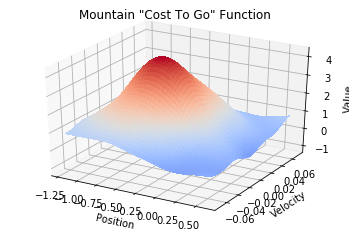

In [138]:
plotValueFunc(baseline)

In [140]:
checkout_actor(30, actor)

Episode 30 [ACTOR] Finish after 522 step
-------------------------------------
